# PYTHON & SQL : ETL processes with Python and SQL

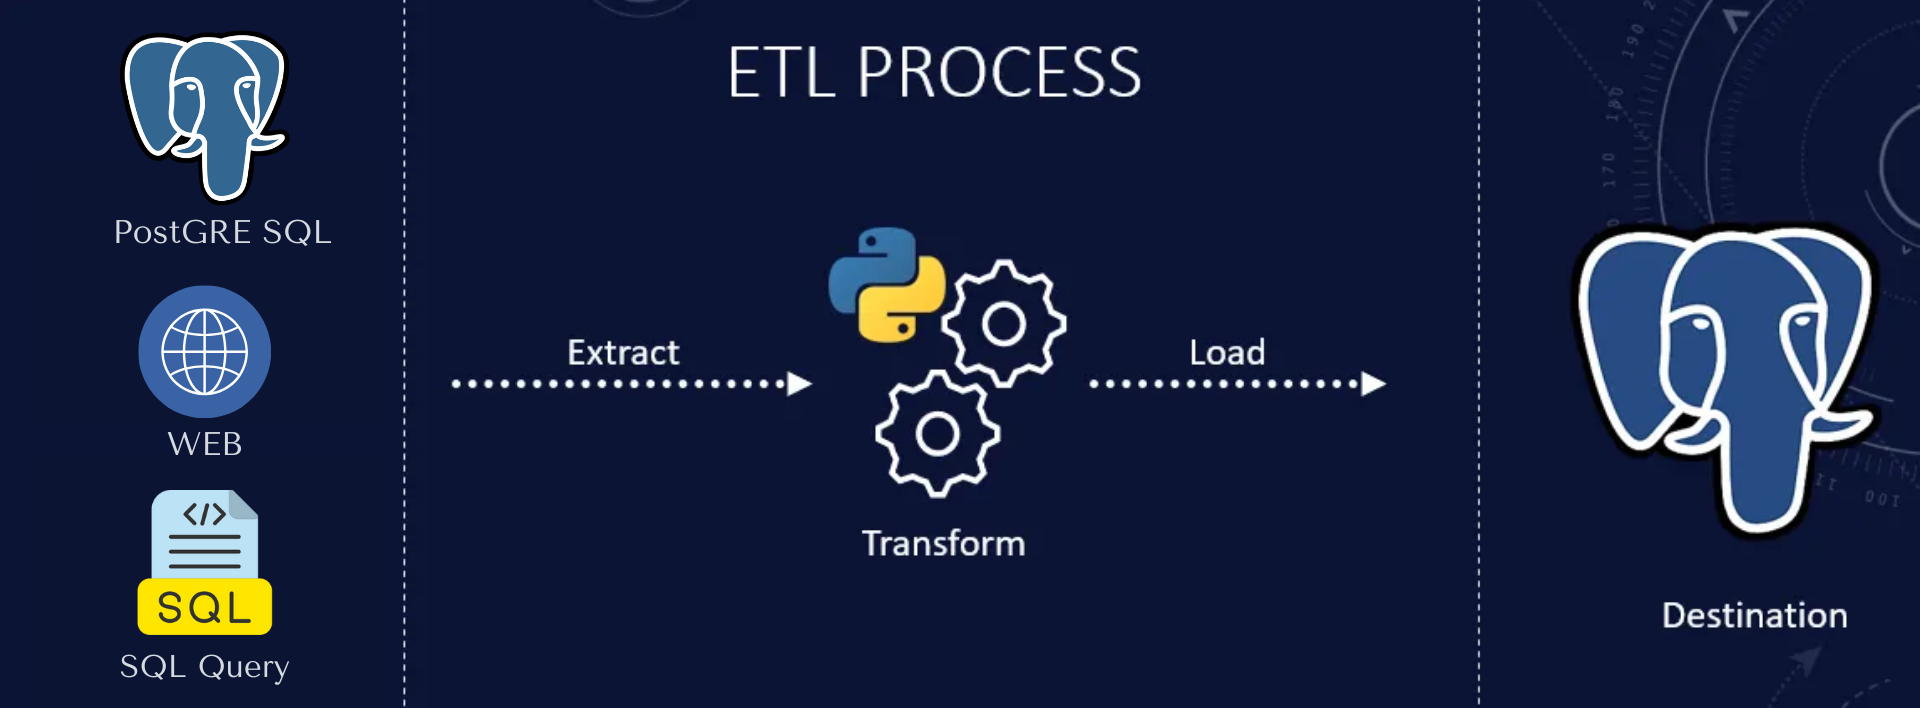

# INTRODUCTION

  
Assume that you want to practice a bit with SQL and to use in a simple project for your database, I needed a dataset for city-district-neighborhood in Turkey, and I found one on the internet. However, its format was not suitable for SQL and also there were some duplicates, so I used Pandas to prepare the data and wanted to insert it into an empty TABLE that I had prepared in SQL installed in my computer (localhost).

**Libraries**:    
Popular libraries for ETL (Extract, Transform, Load) operations with Python on SQL (namely: PostgreSQL, we used PostgreSQL in this notebook):

- `pip install psycopg2`  
- `pip install sqlalchemy`  
- `pip install pandasql`  
- `pip install pandas-gbq`  

* ETL stands for Extract, Transform, Load, and it's a crucial process in data integration.  
* First, data is `extracted` from various sources, such as databases or files.  
* Then, it undergoes `transformation`, where it is cleaned, filtered, and manipulated to fit the desired structure or format.  
* Finally, the transformed data is `loaded` into a target system, typically a data warehouse, making it accessible for analysis and reporting.  
* ETL is fundamental for ensuring data quality, consistency, and making information from diverse sources usable for analytics and decision-making in a unified manner.

In this notebook:  
1. We found some needed data from **web** in an **sql query** format and we **extracted** them  
2. We used **python (mainly pandas)** to **transform** the data  
3. we loaded the procesessed to SQL database
4. Then we needed to change some data that is already loaded in SQL database, so we **extracted** them again to python
5. We **transformed** the data in python
6. We **loaded** back to the SQL database 

In [1]:
import pandas as pd
import psycopg2 
from psycopg2 import sql
from psycopg2.extras import execute_values
import configparser

# EXTRACT

`mahalle.csv` file is composed from an SQL query that we found from github, but the format of the query was not proper to use in our database, moreover it was so long (around 50K records) that we prefered to process via pandas in python

In [2]:
df_unclean = pd.read_csv('mahalle.csv', header=None)
df_unclean

0                   1       2        3   4
0          (1   'BURGAZADA_WRONG'   40139    1103) NaN
1          (2        'HEYBELİADA'   40142    1103) NaN
2          (3         'KINALIADA'   40143    1103) NaN
3          (4             'MADEN'   40140    1103) NaN
4          (5             'NİZAM'   40141    1103) NaN
...       ...                 ...     ...      ...  ..
49675  (49645     'YENİ YALI SK.'       0   40139) NaN
49676  (49646        'YENİCE SK.'       0   40139) NaN
49677  (49647       'YENİYOL SK.'       0   40139) NaN
49678  (49648      'YILDIRIM SK.'       0   40139) NaN
49679  (49649       'ZERAFET SK.'       0   40139) NaN

[49680 rows x 5 columns]

# TRANSFORM

## Data Manipulation with Pandas

In [3]:
# firstly lets arrange our column names so that we can understand the dataframe

df_unclean.columns = ['mahalle_id', 'mahalle_title', 'mahalle_key', 'mahalle_ilcekey', 'WRONG_COLUMN']
df_unclean.sample()

mahalle_id mahalle_title mahalle_key mahalle_ilcekey  WRONG_COLUMN
38081     (38058        'UFUK'       98079           2031)           NaN

In [4]:
# the last column came extra when importing so lets drop that

df_unclean.drop(columns=['WRONG_COLUMN'], inplace=True)

In [5]:
# remove ', () paranthesis, _ whitespaces from all columns

for column in df_unclean.columns:
    df_unclean[column] = df_unclean[column].str.strip("()' ")

df = df_unclean.copy()
df.tail(3)

mahalle_id mahalle_title mahalle_key mahalle_ilcekey
49677      49647   YENİYOL SK.           0           40139
49678      49648  YILDIRIM SK.           0           40139
49679      49649   ZERAFET SK.           0           40139

In [6]:
# the indexes of first column with real indexes are not aligned, 
# actually there are some extra columns which is not observations but sql codes in the data, so i need to remove these rows

indexes = []
for i, v in enumerate(df['mahalle_id']):
    if not v.isnumeric():
        indexes.append(i)

# for example
df.iloc[indexes[:3]]

mahalle_id    mahalle_title    mahalle_key  \
1598  --INSERT INTO `mahalle` (`mahalle_id`  `mahalle_title`  `mahalle_key`   
3175  --INSERT INTO `mahalle` (`mahalle_id`  `mahalle_title`  `mahalle_key`   
4742  --INSERT INTO `mahalle` (`mahalle_id`  `mahalle_title`  `mahalle_key`   

                mahalle_ilcekey  
1598  `mahalle_ilcekey`) VALUES  
3175  `mahalle_ilcekey`) VALUES  
4742  `mahalle_ilcekey`) VALUES

In [7]:
df.drop(indexes, inplace=True)

In [8]:
# Lets also check data types, they need to be the same datatype with sql table

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49649 entries, 0 to 49679
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mahalle_id       49649 non-null  object
 1   mahalle_title    49649 non-null  object
 2   mahalle_key      49649 non-null  object
 3   mahalle_ilcekey  49649 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [9]:
integer_columns = ['mahalle_id', 'mahalle_key', 'mahalle_ilcekey']
df[integer_columns] = df[integer_columns].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49649 entries, 0 to 49679
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mahalle_id       49649 non-null  int32 
 1   mahalle_title    49649 non-null  object
 2   mahalle_key      49649 non-null  int32 
 3   mahalle_ilcekey  49649 non-null  int32 
dtypes: int32(3), object(1)
memory usage: 1.3+ MB


In [10]:
# When trying to INSERT these values into SQL TABLE, i figured out that i have some duplicated rows
# mahalle_key is my `PRIMARY KEY` so i cant allow duplicates

duplicates = df[df.duplicated(subset='mahalle_key', keep=False)==True]
print(len(duplicates))
duplicates[duplicates['mahalle_key']==40203]

173


mahalle_id mahalle_title  mahalle_key  mahalle_ilcekey
131         132     CEVATPAŞA        40203             1886
142         143     CEVATPAŞA        40203             1886

In [11]:
df = df.drop_duplicates(subset='mahalle_key', keep='first')
df['mahalle_key'].duplicated().sum()

0

In [12]:
# Finally i need to make tuples from the rows for inserting data into sql tables
# there are more methods but this is just one of them

tuples_list = [tuple(row) for row in df.values]
tuples_list[:3]

[(1, 'BURGAZADA_WRONG', 40139, 1103),
 (2, 'HEYBELİADA', 40142, 1103),
 (3, 'KINALIADA', 40143, 1103)]

# LOAD

## SQL Connection

In [13]:
# Read password, username etc from configuration file
config = configparser.ConfigParser()
config.read('config.ini', encoding='utf-8')

['config.ini']

**Best to store your credentials like password, username in a config file**

In [14]:
db_params = {
    'host': config.get('Credentials', 'host'),
    'database': config.get('Credentials', 'database'),
    'user': config.get('Credentials', 'user'),
    'password': config.get('Credentials', 'password')
}

try:
    # Establish a connection to the PostgreSQL database
    connection = psycopg2.connect(**db_params)
    print("Connected to the database!")

    # Lets create a cursor object to execute SQL queries
    cursor = connection.cursor()
    
except Exception as e:
    print(f"Error: Unable to connect to the database. {e}")

Connected to the database!


## Database Operations

A view from my table in SQL, the final version

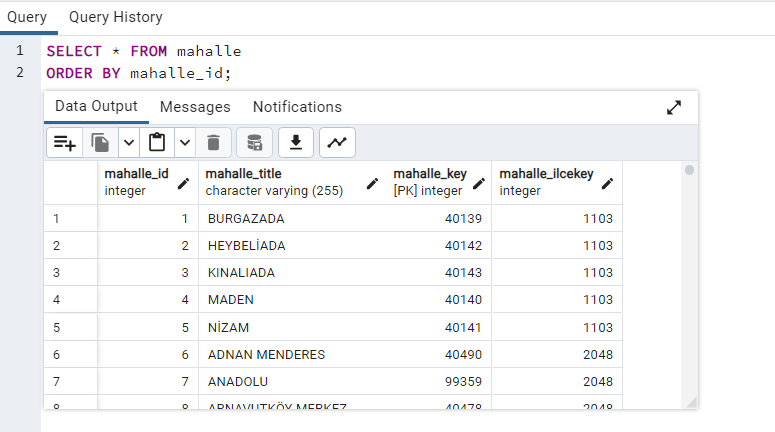

In [15]:
# Lets Create a function for database operations
def insert_values_into_table(table_name, values, cursor):
    '''
    This function is taking a table name from sql database
    Also it take a list of tuples as values for inserting
    Its taking a 'cursor' from psycopg2 library
    it will raise error in case any duplicate trials for any UNIQUE or KEYs
    '''

    insert_query = f"INSERT INTO {table_name} VALUES %s"
    execute_values(cursor, insert_query, values)
    connection.commit()

In [16]:
table_name = 'mahalle'

try: 
    # implement the database operation
    insert_values_into_table(table_name = table_name, values = tuples_list, cursor=cursor)
    print(f"{len(tuples_list)} values inserted into {table_name} successfully")

except Exception as e:
    print(f"Error: Unable to insert data into {table_name}. {e}")

49513 values inserted into mahalle successfully


------------------------

# Data Manipulation in SQL tables from Python

## EXTRACT : Read data

In [17]:
# WRITE AN SQL QUERY
sql_query = f"""
    SELECT * FROM {table_name}
    """

try:
    # Execute the query
    cursor.execute(sql_query)

    # Fetch all the rows as a list of tuples
    rows = cursor.fetchall()

    # save datas into a DataFrame using the column names from the cursor description
    column_names = [desc[0] for desc in cursor.description]
    df_from_sql = pd.DataFrame(rows, columns=column_names).sort_values(by='mahalle_id')
    print(f"Length of our dataframe is: {len(df_from_sql)} \n")
    print(df_from_sql.head(3))

except Exception as e:
    print(f"Error: Unable to execute the query. {e}")

Length of our dataframe is: 49513 

   mahalle_id    mahalle_title  mahalle_key  mahalle_ilcekey
0           1  BURGAZADA_WRONG        40139             1103
1           2       HEYBELİADA        40142             1103
2           3        KINALIADA        40143             1103


## TRANSFORM: Update a value

**We identified that BURGAZADA written wrongly as BURGAZADA_WRONG, so we need to change it**

In [18]:
# current status of database with burgazada
connection = psycopg2.connect(**db_params)
cursor = connection.cursor()

sql_query = """
    SELECT * FROM mahalle
    WHERE mahalle_key=40139
"""

cursor.execute(sql_query)
sql_query_result = cursor.fetchall()
print(sql_query_result)

cursor.close()
connection.close()

[(1, 'BURGAZADA_WRONG', 40139, 1103)]


## LOAD: Commit the changes

In [19]:
connection = psycopg2.connect(**db_params)
cursor = connection.cursor()

table_name = "mahalle"
primary_key_column = "mahalle_key"
primary_key_value = 40139
column_to_change = 'mahalle_title'
new_value = 'BURGAZADA'

# Corrected SQL query using string formatting and placeholders for values
sql_query = f"""
    UPDATE {table_name}
    SET {column_to_change} = %s
    WHERE {primary_key_column} = %s
"""

# Execute the query with the new value and primary key as parameters
cursor.execute(sql_query, (new_value, primary_key_value))

# Commit the changes to the database
connection.commit()

# lets check whether we are successfull or not
sql_query = """
    SELECT * FROM mahalle
    WHERE mahalle_key=40139
"""

cursor.execute(sql_query)
connection.commit()

sql_query_result = cursor.fetchall()
print(sql_query_result)

cursor.close()
connection.close()

[(1, 'BURGAZADA', 40139, 1103)]
